<a href="https://colab.research.google.com/github/dkle91/Hybrid-CFD-DL-method-for-cyclone-pressure-drop-prediction/blob/main/Hybrid_DNN_FVM_for_Pressure_Drop_Prediction_of_Cyclone_Separators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import sys
sys.path.insert(0, 'drive/content/')
import scipy.io
from keras import models 
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files

# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
# Load data
data = np.empty([243,5], dtype=DTYPE)
data = np.loadtxt('Input_data.csv',delimiter=',')
shuffle_data = shuffle(data)
ratio = shuffle_data[:,4]/shuffle_data[:,3]

In [3]:
# Set random seed for reproducible results
tf.random.set_seed(0)

# 1. Activation function: 0-tanh, 1-sigmoid, 2-Relu
activation = 'sigmoid'
# 2. Optimizer: 0-Adam, 1-SGD, 2-RMSprop
optimizer = 'SGD'
# 3. Learning rate: 0-1e-2, 1-1e-3, 2-1e-4
learn_rate = 5e-2
# 4. Number of epochs: 0-2500, 1-5000, 2-7500
N_epoch = 20000
# 5. Number of neurons: 0-10, 1-20, 2-30
num_neurons_per_layer =  50
# 6. Number of layers: 0-6, 1-8, 2-10
num_hidden_layers = 2
# 7. Batch size
batch = 1


In [4]:
#Normalize the data
# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(shuffle_data)
# apply transform
normalized_data = scaler.transform(shuffle_data)
# Prepare train & test data
x_train = tf.convert_to_tensor(normalized_data[:195,:3], dtype=DTYPE)
y_train = tf.convert_to_tensor(ratio[:195], dtype=DTYPE)
x_val = tf.convert_to_tensor(normalized_data[195:219,:3], dtype=DTYPE)
y_val = tf.convert_to_tensor(ratio[195:219], dtype=DTYPE)

#5-fold cross validation

x_test = tf.convert_to_tensor(normalized_data[219:243,:3], dtype=DTYPE)
y_test = tf.convert_to_tensor(ratio[219:243], dtype=DTYPE)


In [5]:
model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
model.add(tf.keras.Input(3))

    # Append hidden layers
for _ in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
        activation=tf.keras.activations.get(activation),
        kernel_initializer='uniform'))

    # Output is one-dimensional
model.add(tf.keras.layers.Dense(1))
    


In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

model.compile(loss='mse', optimizer= optimizer, metrics=['accuracy'])

In [7]:
#log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train,
    y_train, 
    validation_data=(x_val, y_val),
    epochs= N_epoch, batch_size = batch,  verbose=2)

Streaming output truncated to the last 5000 lines.
Epoch 17501/20000
195/195 - 0s - loss: 0.7421 - accuracy: 0.0000e+00 - val_loss: 0.7656 - val_accuracy: 0.0000e+00 - 369ms/epoch - 2ms/step
Epoch 17502/20000
195/195 - 0s - loss: 0.7349 - accuracy: 0.0000e+00 - val_loss: 0.7606 - val_accuracy: 0.0000e+00 - 344ms/epoch - 2ms/step
Epoch 17503/20000
195/195 - 0s - loss: 0.7402 - accuracy: 0.0000e+00 - val_loss: 0.6828 - val_accuracy: 0.0000e+00 - 342ms/epoch - 2ms/step
Epoch 17504/20000
195/195 - 0s - loss: 0.7402 - accuracy: 0.0000e+00 - val_loss: 0.7174 - val_accuracy: 0.0000e+00 - 332ms/epoch - 2ms/step
Epoch 17505/20000
195/195 - 0s - loss: 0.7390 - accuracy: 0.0000e+00 - val_loss: 0.7514 - val_accuracy: 0.0000e+00 - 332ms/epoch - 2ms/step
Epoch 17506/20000
195/195 - 0s - loss: 0.7382 - accuracy: 0.0000e+00 - val_loss: 0.6501 - val_accuracy: 0.0000e+00 - 358ms/epoch - 2ms/step
Epoch 17507/20000
195/195 - 0s - loss: 0.7389 - accuracy: 0.0000e+00 - val_loss: 0.7830 - val_accuracy: 0.000

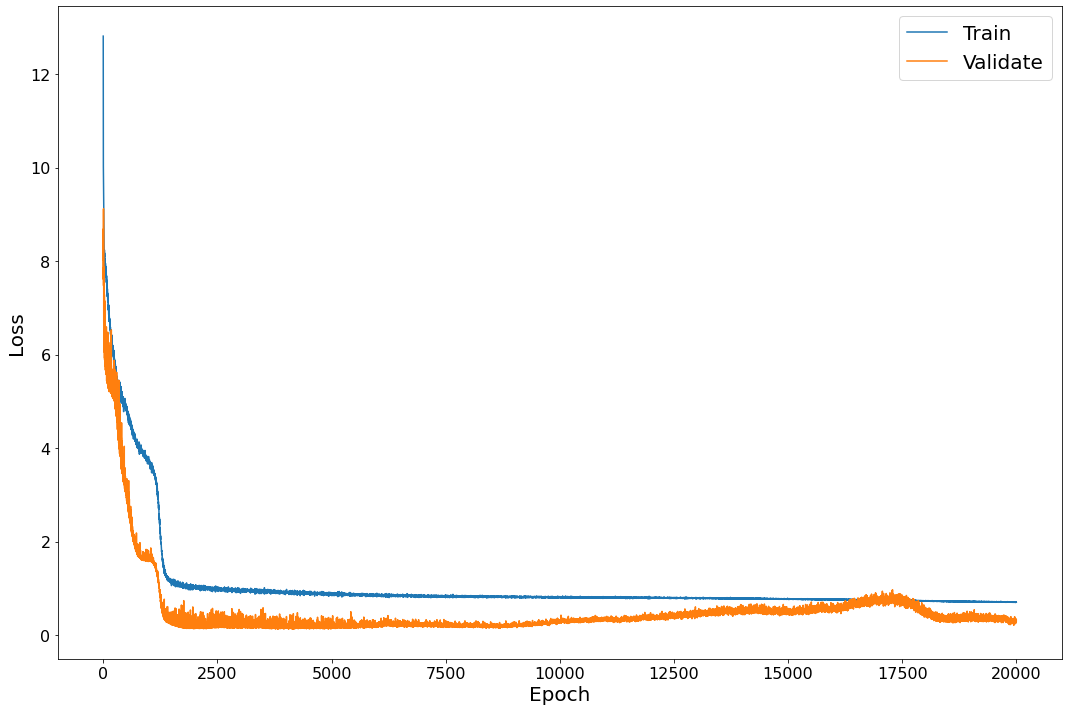

In [8]:
# summarize history for loss
plt.figure(figsize=(18,12))
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
#plt.title('Loss', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.legend(['Train', 'Validate'], loc='upper right', fontsize=20)
plt.savefig('Loss graph.jpeg', bbox_inches='tight', dpi=600);
plt.show()

In [9]:
# create scaler
scaler1 = MinMaxScaler()
# fit scaler on data
all = data[:,:3]
scaler1.fit(all)
# apply transform
normalized_all = scaler1.transform(all)
all_test = tf.convert_to_tensor(normalized_all, dtype=DTYPE)
test_all = model.predict(all_test)
test_all
np.savetxt('Hyrbrid results.csv', test_all)

In [11]:
# Predict for all dataset
predict_test = model.predict(x_test)
exact_test = y_test.numpy()
exact_test = exact_test.reshape(-1,1)
predict_train = model.predict(x_train)
exact_train = y_train.numpy()
exact_train = exact_train.reshape(-1,1)
predict_val = model.predict(x_val)
exact_val = y_val.numpy()
exact_val = y_val.numpy()

In [12]:
#Evaluate the errors
#Train error
exact_train = y_train.numpy()
exact_train = exact_train.reshape(-1,1)
error_train = np.absolute(predict_train - exact_train)*100/exact_train
print('The mean train error is: ', np.average(error_train))
#Validate error
exact_val = y_val.numpy()
exact_val = exact_val.reshape(-1,1)
error_val = np.absolute(predict_val - exact_val)*100/exact_val
print('The mean validation error is: ', np.average(error_val))
#Test error
exact_test = y_test.numpy()
exact_test = exact_test.reshape(-1,1)
error_test = np.absolute(predict_test - exact_test)*100/exact_test
print('The mean test error is: ', np.average(error_test))

The mean train error is:  3.4763865
The mean validation error is:  8.65206
The mean test error is:  17.096037
